In [1]:
# Importing all libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Functions import *

#### Helper Functions

In [2]:
#helper functions
def compute_path_gains(dTU, dSU, dTS, M, c0=1e-3, d0=1, aTU=3.5, aSU=2.0, aTS = 2.0):
    GTU = c0 * (dTU / d0) ** (-aTU)
    
    # Initialize GSU and GTS
    GSU = np.zeros((dSU.shape[0], M))
    GTS = np.zeros((dTS.shape[0], M))
    
    # Compute GSU for each user and each IRS element
    for k in range(dSU.shape[0]):
        for m in range(M):
            GSU[k, m] = c0 * (dSU[k, 0] / d0) ** (-aSU)
    
    # Compute GTS for each IRS face and each element
    for l in range(dTS.shape[0]):
        for m in range(M):
            GTS[l, m] = c0 * (dTS[l, 0] / d0) ** (-aTS)
    
    return GTU, GSU, GTS

def generate_large_scale_fading_new(dTS, dSU, L, K, closest_face_indices):
    numerator = 1
    alpha_kl = np.zeros((K, L))

    if L == 1:
        dTS_l = dTS[0]  # Distance from BS to the single face
        for k in range(K):
            dSU_k = dSU[k]  # Distance from face to user k
            denominator = 1
            alpha_kl[k, 0] = numerator / denominator
    else:
        for k in range(K):
            l = closest_face_indices[k]  # Closest face for user k
            dTS_l = dTS[l]  # Distance from BS to face l
            dSU_k = dSU[k]  # Distance from face l to user k
            denominator = (1 - np.cos(np.pi / L))**2
            alpha_kl[k, l] = numerator / denominator

    return alpha_kl


def compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor):
    hRT = np.zeros(K, dtype=complex)
    hRI = np.zeros((K, M), dtype=complex)
    hIT = np.zeros((L, M), dtype=complex)

    for k in range(K):
        # Compute hRT (channel between BS and users)
        hRT_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
        hRT_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
        hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)

        # Compute hRI (channel between IRS and users)
        for m in range(M):
            hRI_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
            hRI_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
            hRI[k, m] = np.sqrt(GSU[k, m]) * (np.sqrt(K_factor / (1 + K_factor)) * hRI_LoS + np.sqrt(1 / (1 + K_factor)) * hRI_NLoS)

    # Compute hIT (channel between IRS and BS)
    for l in range(L):
        for m in range(M):
            hIT_LoS = np.exp(1j * 2 * np.pi * np.random.rand())  # Deterministic LoS component
            hIT_NLoS = np.sqrt(1 / 2) * (np.random.randn() + 1j * np.random.randn())  # NLoS component
            hIT[l, m] = np.sqrt(GTS[l, m]) * (np.sqrt(K_factor / (1 + K_factor)) * hIT_LoS + np.sqrt(1 / (1 + K_factor)) * hIT_NLoS)
    
    hRT = hRT.reshape(-1, 1)  # Shape: (K, 1)
    hRI = hRI.transpose()    # Shape: (M, K)
    
    return hRT, hRI, hIT

def compute_SNR_NOMA(link_budget, noise_floor):
    SNR = link_budget - noise_floor
    return dBm2pow(SNR)



#### System parameters

Defining Parameters

    Nt = Number of transmit antennas (SISO = 1)    
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

### Initialize constants

In [3]:

Nt = 1
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 20e6
NF = 10
noise = -174 + 10*np.log10(BW) + NF


#### Network Parameters

In [4]:
def init_network_params(L, BASE_STATION_POSITION,USER_POS):
 #   BASE_STATION_POSITION = (0, 0, 35)
    print("==============NETWORK PARAMETERS BEING INITIATED================")
    dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
    RATE_THRESHOLD = 25
    
    # IRS Position
    IRS_position = (10, 10, 5)
    
    # IRS elements and dimensions
    ####################################################################
    #####                                                       33333333
    ###                                                         33333333
    #3333333333333333333333333333333333333333333333333333333333333333333
    #L = 1 # Number of faces for the IRS (change this for different polygons)
    M = 360 // L
    nIRSrow = M // 6
    nIRScol = M // nIRSrow
    edge_length = 5  # Length of each edge of the IRS in meters
    z_height = edge_length  # Fixed height equal to edge_length
    print("RATE THRESHOLD: ", RATE_THRESHOLD)
    print("IRS position is: ", IRS_position)
    print("Base station position is: ",BASE_STATION_POSITION )
    
    # Assuming previous code parts
    radius = 100  # Range for generation of users within IRS
   # USER_POS = np.array([[30, 30, 1], [50, 50, 1]])
    K = len(USER_POS)
    locU = USER_POS 
    xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
    locT = np.array([BASE_STATION_POSITION])  # Position of BS
    coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)
    dTU, dSU, dTS, closest_face_indices = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position)
    print("Number of users are: ", K, " with a radius of ", radius )
    print("dTU: {}, dSU: {}, dTK: {}, M: {}".format(dTU,dSU,dTS,M))
    return radius, dTU, dSU, dTS,M,K,closest_face_indices

##### Generate variables, circle and fading

In [26]:
def gen_var(L, BASE_STATION_POS, radius,dTU,dSU,dTS, M,K,closest_face_indices,NUM_SIMULATIONS):
    print("===============GENERATING VARIABLES=========================")
    # Generate circle and sectors data for plotting
    x_circle, y_circle, z_circle, sector_lines = generate_circle_and_sectors_3D(BASE_STATION_POS, radius, L)
    # Compute path gains and channels
    
    GTU, GSU, GTS = compute_path_gains(dTU, dSU, dTS, M)
    # Different values of L (number of IRS faces) to simulate

    Pt = np.arange(0, 41, 0.1)  # in dBm
        # Generate large scale fading coefficients once
    alpha_kl = generate_large_scale_fading_new(dTS, dSU, L, K, closest_face_indices)
    # Take the maximum value in each row of alpha_kl to create a matrix of (K, 1)
    alpha_kl_new = np.max(alpha_kl, axis=1).reshape(K, 1)
    G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)
    
    # Variables declared
    outage_probability_disc = np.zeros((NUM_SIMULATIONS, K))
    arr_SNR_disc = np.zeros((NUM_SIMULATIONS, K))
    arr_lb_disc = np.zeros((NUM_SIMULATIONS, K))
    average_SNR_1 = []
    
    # Initialize arrays to store results for each L value
    h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
    h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
    h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
        # Perform simulations
    for i in range(NUM_SIMULATIONS):
        print("Simulation: ", i)
        
        # Compute channels
        hTU, hSU, hTS = compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor=10)
    
        # Store results for each simulation
        h_dk_3d[i] = hTU  # BS to users
        h_rk1_3d[i] = hSU  # IRS to users
        h_rk1_h_3d[i] = np.conj(np.transpose(hSU))  # Transpose IRS to users
        G1_3d[i] = hTS  # BS to all IRS faces and their elements
        #print("Gain from BS to all IRS faces an elements", G1_3d[i])
        
    print("===================RUNNING SIMULATION===========================")
    for T in Pt: # Converting the dBm power to watts for further use
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        # Initialize sum-rates for this case
        SNR = []
        print("===========================For Power of : ", T," ==================================")
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            print("Simulation number: ", s)
            h_dk = h_dk_3d[s]  # Shape: (K, 1)
            h_rk = h_rk1_3d[s]  # Shape: (M, K)
            h_rk_transpose = h_rk1_h_3d[s]  # Shape: (K, M)
            G = G1_3d[s]  # Shape: (L, M)
         #   print("G is")
          #  print(np.info(G))
           # print("G1_3d is")
            #print(np.info(G1_3d)) '''
            
            # Compute theta and product matrix
            theta = theta_matrix_ideal(1, h_dk, h_rk, G, K, M, L)
            results_array = prod_matrix(theta, h_rk_transpose, G, K, M, L, closest_face_indices)
            
            # Calculate sum rate
            arr_link_budget = np.abs((TRANSMIT_POWER_WATTS * alpha_kl_new)**0.5 * (h_dk + results_array))
            arr_link_budget = pow2dBm((arr_link_budget)**2)
            arr_SNR_disc[s, :] = compute_SNR_NOMA(arr_link_budget, noise).flatten()
            SNR.append(arr_SNR_disc[s])
            print("arr_link_budget: ", arr_link_budget)
        # Calculate average sum rate across simulations for this Pt
        average_SNR_1.append(np.mean(SNR, axis=0))
        #print("AVERAGE SNR: ", average_SNR_1)
    
    # Convert list to numpy array
    average_SNR_1 = np.array(average_SNR_1)
    average_SNR_1 = average_SNR_1.reshape(K, len(Pt))
    
    print(np.shape(average_SNR_1))
    
    #Compute mean SNR for each row
    mean_SNR = (np.mean(average_SNR_1, axis=1))

    return mean_SNR, average_SNR_1, Pt

### Calculate rates from mean and avg snr

In [15]:

def calc_rates(mean_SNR, average_SNR_1):
    print("Calculating R1,R2 values from mean SNR")
    # Determine which row corresponds to SNR1 and SNR2 based on mean SNR
    if mean_SNR[0] > mean_SNR[1]:
        SNR1 = average_SNR_1[0, :]
        SNR2 = average_SNR_1[1, :]
    else:
        SNR1 = average_SNR_1[1, :]
        SNR2 = average_SNR_1[0, :]
    
    a = 0.3  # Power allocation coefficient for user 1
    
    # Compute rates
    R2 = np.log2(1 + (1-a) * SNR2 / (a * SNR2 + 1))
    R1 = np.log2(1 + a * SNR1)
    
    print(np.shape(R1))
    print(np.shape(R2))
    return R1,R2

### Graph stuff

In [27]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def graph(R1,R2,Pt):
    window_size = 10  # Window size for moving average
    
    # Apply moving average for smoothing
    R1 = moving_average(R1, window_size)
    R2 = moving_average(R2, window_size)
    
    # Plotting
    plt.plot(Pt, R1, label='R1 (User 1)')
    plt.plot(Pt, R2, label='R2 (User 2)')
    plt.xlabel('Transmit Power (dBm)')
    plt.ylabel('Rate (bps/Hz)')
    plt.title('Rate vs. Transmit Power')
    plt.xlim(0,40)
    plt.legend()
    plt.grid(True)
    plt.show()

### main function wrapping it all together

In [28]:
def BDIRS_NOMA_PERFORMANCE(L,NUM_SIMULATIONS,noise,BASE_STATION_POSITION,USER_POS):
   # Nt,f,c,Lambda,halfLambda,quarterLambda,BW,NF,noise = init_constants()
    radius, dTU, dSU, dTS,M,K,closest_face_indices = init_network_params(L,BASE_STATION_POSITION,USER_POS )
    mean_snr,average_SNR_1,Pt =  gen_var(L, BASE_STATION_POSITION, radius,dTU,dSU,dTS, M,K,closest_face_indices,NUM_SIMULATIONS)
    r1,r2 = calc_rates(mean_snr,average_SNR_1)
    graph(r1,r2,Pt)

In [29]:
L = 1
num_sim = 10
bs_pos = (0, 0, 35)
users_pos = np.array([[30, 30, 1], [50, 50, 1]])


==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (10, 10, 5)
Base station position is:  (0, 0, 35)
Number of users are:  2  with a radius of  100
dTU: [[54.36910888]
 [78.46018098]], dSU: [[2.04140492e+16]
 [2.04140492e+16]], dTK: [[2.04140492e+16]], M: 360
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-92.66532634]
 [-95.24843693]]
Simulation number:  1
arr_link_budget:  [[-91.30328188]
 [-95.80409264]]
Simulation number:  2
arr_link_budget:  [[-92.75766297]
 [-94.93787694]]
Simulation number:  3
arr_link_budget:  [[-93.07018168]
 [-95.27066406]]
Simulation number:  4
arr_link_budget

C:\Users\DNS\AppData\Local\Temp\ipykernel_2748\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


===========================For Power of :  0.30000000000000004  ==================================
Simulation number:  0
arr_link_budget:  [[-92.36532634]
 [-94.94843693]]
Simulation number:  1
arr_link_budget:  [[-91.00328188]
 [-95.50409264]]
Simulation number:  2
arr_link_budget:  [[-92.45766297]
 [-94.63787694]]
Simulation number:  3
arr_link_budget:  [[-92.77018168]
 [-94.97066406]]
Simulation number:  4
arr_link_budget:  [[-89.83195725]
 [-95.38771322]]
Simulation number:  5
arr_link_budget:  [[-90.44987415]
 [-95.85563404]]
Simulation number:  6
arr_link_budget:  [[-90.66716338]
 [-94.0825578 ]]
Simulation number:  7
arr_link_budget:  [[-90.37129166]
 [-97.75059383]]
Simulation number:  8
arr_link_budget:  [[-88.40206382]
 [-99.19323825]]
Simulation number:  9
arr_link_budget:  [[-92.34044804]
 [-95.071578  ]]
===========================For Power of :  0.4  ==================================
Simulation number:  0
arr_link_budget:  [[-92.26532634]
 [-94.84843693]]
Simulation numb

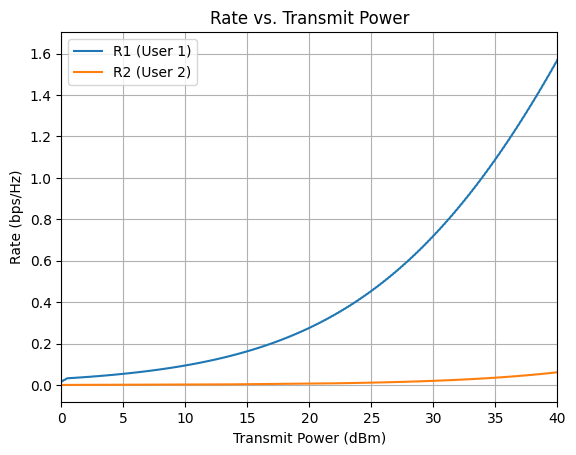

In [30]:
BDIRS_NOMA_PERFORMANCE(L, num_sim, noise, bs_pos,users_pos)

==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (10, 10, 5)
Base station position is:  (0, 0, 35)
Number of users are:  2  with a radius of  100
dTU: [[54.36910888]
 [78.46018098]], dSU: [[28.21790212]
 [56.35822921]], dTK: [[33.32041416]
 [33.01893396]], M: 180
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-90.00520628]
 [-98.81327154]]
Simulation number:  1
arr_link_budget:  [[-89.0918194 ]
 [-94.85369293]]
Simulation number:  2
arr_link_budget:  [[-91.80696818]
 [-93.84801443]]
Simulation number:  3
arr_link_budget:  [[-93.47645672]
 [-99.00437875]]
Simulation number:  4
arr_link_

C:\Users\DNS\AppData\Local\Temp\ipykernel_2748\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


arr_link_budget:  [[-89.95440474]
 [-98.79539703]]
Simulation number:  7
arr_link_budget:  [[-85.93276004]
 [-96.78813409]]
Simulation number:  8
arr_link_budget:  [[-82.61780757]
 [-92.05177552]]
Simulation number:  9
arr_link_budget:  [[-90.81550883]
 [-94.29649994]]
===========================For Power of :  1.4000000000000001  ==================================
Simulation number:  0
arr_link_budget:  [[-88.60520628]
 [-97.41327154]]
Simulation number:  1
arr_link_budget:  [[-87.6918194 ]
 [-93.45369293]]
Simulation number:  2
arr_link_budget:  [[-90.40696818]
 [-92.44801443]]
Simulation number:  3
arr_link_budget:  [[-92.07645672]
 [-97.60437875]]
Simulation number:  4
arr_link_budget:  [[-89.42502439]
 [-91.4267012 ]]
Simulation number:  5
arr_link_budget:  [[-90.77692826]
 [-91.16605988]]
Simulation number:  6
arr_link_budget:  [[-89.85440474]
 [-98.69539703]]
Simulation number:  7
arr_link_budget:  [[-85.83276004]
 [-96.68813409]]
Simulation number:  8
arr_link_budget:  [[-82.51

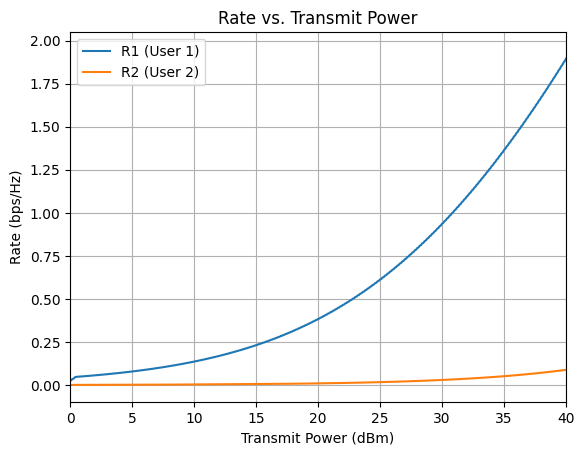

In [31]:
BDIRS_NOMA_PERFORMANCE(2, num_sim, noise, bs_pos,users_pos)

==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (10, 10, 5)
Base station position is:  (0, 0, 35)
Number of users are:  2  with a radius of  100
dTU: [[54.36910888]
 [78.46018098]], dSU: [[27.18852368]
 [55.32041492]], dTK: [[33.78634473]
 [32.75997283]
 [33.03811572]], M: 120
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-95.68839522]
 [-87.37913616]]
Simulation number:  1
arr_link_budget:  [[-91.01311407]
 [-90.14520904]]
Simulation number:  2
arr_link_budget:  [[-89.04418143]
 [-89.46477197]]
Simulation number:  3
arr_link_budget:  [[-89.53696133]
 [-90.45198208]]
Simulation numbe

C:\Users\DNS\AppData\Local\Temp\ipykernel_2748\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


arr_link_budget:  [[-79.34567399]
 [-90.3156377 ]]
Simulation number:  5
arr_link_budget:  [[-81.21812721]
 [-87.74391969]]
Simulation number:  6
arr_link_budget:  [[-80.8429953 ]
 [-89.13313649]]
Simulation number:  7
arr_link_budget:  [[-82.66581705]
 [-88.78263894]]
Simulation number:  8
arr_link_budget:  [[-81.52861099]
 [-89.29729415]]
Simulation number:  9
arr_link_budget:  [[-84.68417441]
 [-89.74389209]]
===========================For Power of :  2.6  ==================================
Simulation number:  0
arr_link_budget:  [[-93.08839522]
 [-84.77913616]]
Simulation number:  1
arr_link_budget:  [[-88.41311407]
 [-87.54520904]]
Simulation number:  2
arr_link_budget:  [[-86.44418143]
 [-86.86477197]]
Simulation number:  3
arr_link_budget:  [[-86.93696133]
 [-87.85198208]]
Simulation number:  4
arr_link_budget:  [[-79.24567399]
 [-90.2156377 ]]
Simulation number:  5
arr_link_budget:  [[-81.11812721]
 [-87.64391969]]
Simulation number:  6
arr_link_budget:  [[-80.7429953 ]
 [-89.0

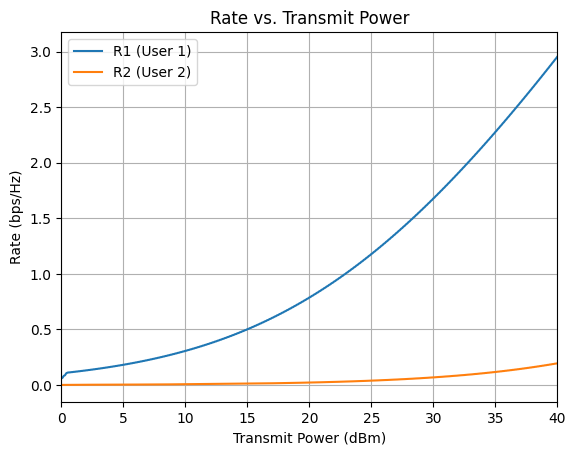

In [32]:
BDIRS_NOMA_PERFORMANCE(3, num_sim, noise, bs_pos,users_pos)

==============NETWORK PARAMETERS BEING INITIATED================
RATE THRESHOLD:  25
IRS position is:  (10, 10, 5)
Base station position is:  (0, 0, 35)
Number of users are:  2  with a radius of  100
dTU: [[54.36910888]
 [78.46018098]], dSU: [[25.21084755]
 [53.3229172 ]], dTK: [[34.75581732]
 [34.00036396]
 [32.29583679]
 [32.01754285]
 [33.57179081]], M: 72
===============GENERATING VARIABLES=========================
Simulation:  0
Simulation:  1
Simulation:  2
Simulation:  3
Simulation:  4
Simulation:  5
Simulation:  6
Simulation:  7
Simulation:  8
Simulation:  9
===================RUNNING SIMULATION===========================
===========================For Power of :  0.0  ==================================
Simulation number:  0
arr_link_budget:  [[-75.25357341]
 [-80.42749325]]
Simulation number:  1
arr_link_budget:  [[-77.03384615]
 [-80.3037082 ]]
Simulation number:  2
arr_link_budget:  [[-82.57718902]
 [-88.55171009]]
Simulation number:  3
arr_link_budget:  [[-74.35960051]
 [-8

C:\Users\DNS\AppData\Local\Temp\ipykernel_2748\1306494156.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hRT[k] = np.sqrt(GTU[k]) * (np.sqrt(K_factor / (1 + K_factor)) * hRT_LoS + np.sqrt(1 / (1 + K_factor)) * hRT_NLoS)


arr_link_budget:  [[-72.47341088]
 [-77.45857054]]
===========================For Power of :  2.1  ==================================
Simulation number:  0
arr_link_budget:  [[-73.15357341]
 [-78.32749325]]
Simulation number:  1
arr_link_budget:  [[-74.93384615]
 [-78.2037082 ]]
Simulation number:  2
arr_link_budget:  [[-80.47718902]
 [-86.45171009]]
Simulation number:  3
arr_link_budget:  [[-72.25960051]
 [-78.12140476]]
Simulation number:  4
arr_link_budget:  [[-78.38871379]
 [-81.96689887]]
Simulation number:  5
arr_link_budget:  [[-72.82824575]
 [-82.41513707]]
Simulation number:  6
arr_link_budget:  [[-72.16898671]
 [-79.39864291]]
Simulation number:  7
arr_link_budget:  [[-73.74252403]
 [-80.87066524]]
Simulation number:  8
arr_link_budget:  [[-73.89189819]
 [-88.70132843]]
Simulation number:  9
arr_link_budget:  [[-72.37341088]
 [-77.35857054]]
===========================For Power of :  2.2  ==================================
Simulation number:  0
arr_link_budget:  [[-73.0535734

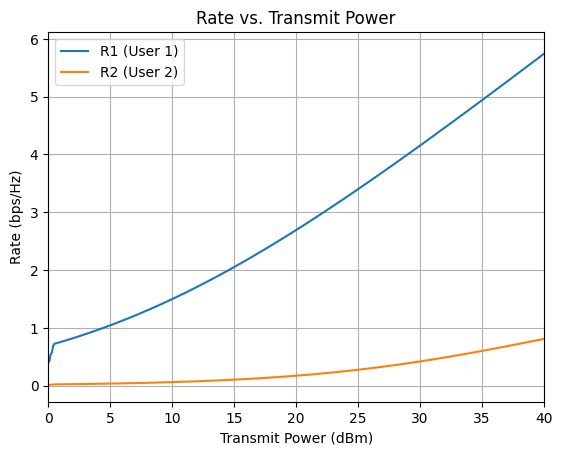

In [33]:
BDIRS_NOMA_PERFORMANCE(5, num_sim, noise, bs_pos,users_pos)

##### Observations
increasing L increases R1 rate as well as R2 but not as much